In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.notebook import tqdm

In [11]:
def get_device(cuda_preference=True):
    print('cuda available:', torch.cuda.is_available(), 
        '; cudnn available:', torch.backends.cudnn.is_available(),
        '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device=get_device()
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Quadro RTX 6000
64 CPUs available


In [12]:
class CFG():
    train_path=f"optiver/train.csv"
    test_path=f"optiver/example_test_files/test.csv"
    model_path=f'model/best_score_optiver.pt'
    n_epoch=100
    batch_size=256
    lr=0.001
    loss_fn=nn.L1Loss()
    layers = [64,64,32,32,16,16,8,8]
    wd=0.0001 
    task='Regression'

cfg=CFG()

# Data

In [13]:
df_raw = pd.read_csv(cfg.train_path)
# df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
# sample_sub = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
# rev_target = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

df_raw.isna().sum(axis=0) / len(df_raw)
df_raw

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [14]:
def add_historic_features(df, cols):
    for col in cols:
        df[col+"_shift1"] = df[["stock_id", "date_id", col]].groupby(["stock_id","date_id"]).shift(1)
        df[col+"_shift2"] = df[["stock_id", "date_id", col]].groupby(["stock_id","date_id"]).shift(2)
        df[col+"_shift3"] = df[["stock_id", "date_id", col]].groupby(["stock_id","date_id"]).shift(3)
    return df

In [15]:
def add_info_columns(raw_df):
    df = raw_df.copy()
    df[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]] = df[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]].fillna(1.0)
    
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size'] 
    df["imbalance"] = df["imbalance_size"] * df["imbalance_buy_sell_flag"]
#     df.drop(columns=["imbalance_size","imbalance_buy_sell_flag"], inplace=True)
    
    df['ordersize_imbalance'] = (df['bid_size']-df['ask_size']) / (df['bid_size']+df['ask_size'])
    df['matching_imbalance'] = (df['imbalance_size']-df['matched_size']) / (df['imbalance_size']+df['matched_size']) 
    
    df = add_historic_features(df, ["imbalance","imbalance_ratio","reference_price","wap","matched_size"])
        
#     df = pd.concat((df, pd.get_dummies(df["stock_id"]).astype(int)), axis=1)
#     df = df.drop(columns="stock_id")
    
    return df

In [16]:
df = add_info_columns(df_raw)
df.dropna(inplace=True)
# print(df)
df.isna().sum(axis=0)

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
imbalance_ratio            0
imbalance                  0
ordersize_imbalance        0
matching_imbalance         0
imbalance_shift1           0
imbalance_shift2           0
imbalance_shift3           0
imbalance_ratio_shift1     0
imbalance_ratio_shift2     0
imbalance_ratio_shift3     0
reference_price_shift1     0
reference_price_shift2     0
reference_price_shift3     0
wap_shift1                 0
wap_shift2                 0
wap_shift3                 0
matched_size_shift1        0
matched_size_s

In [17]:
x_cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]
y_cols = ["target"]

In [18]:
means = df[x_cols].mean(0)
stds = df[x_cols].std(0)

In [19]:
def normalize_features(x):
    return (x - means) / (stds+1e-8)

In [20]:
def get_xy(df):
    x = df[x_cols]
    x = normalize_features(x)
    
    y = df[y_cols]
    
    return x.values, y.values

In [21]:
def get_dataloaders(df, batch_size=cfg.batch_size):
    (x,y) = get_xy(df)
    
    x_tensor = torch.Tensor(x).to(device)
    y_tensor = torch.Tensor(y).to(device)
    
    full_dataset = TensorDataset(x_tensor, y_tensor)
    train_dataset, valid_dataset = random_split(full_dataset, [0.8,0.2])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=min(batch_size*4, len(valid_dataset)), drop_last=True)
    return (train_dataloader, valid_dataloader)

In [22]:
train_dataloader, valid_dataloader = get_dataloaders(df)

# Model

In [23]:
layers = cfg.layers

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(len(x_cols), layers[0]),
            nn.ReLU()
        )
        
        for i in range(len(layers)-1):
            self.relu_stack.append(nn.Dropout(0.3))
            self.relu_stack.append(nn.Linear(layers[i], layers[i+1]))
            self.relu_stack.append(nn.ReLU())
        self.relu_stack.append(nn.Linear(layers[-1],1))

    def forward(self, x):
        output = self.relu_stack(x)
        return output
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        if m.out_features == 1:
            torch.nn.init.xavier_normal_(m.weight)

In [24]:
def train_loop(dataloader, model,optimizer, loss_fn=cfg.loss_fn):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return train_loss.detach().cpu().numpy() / num_batches


def valid_loop(dataloader, model, loss_fn=cfg.loss_fn):
    model.eval()
    num_batches = len(dataloader)
    valid_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valid_loss += loss_fn(pred, y).detach().cpu().numpy()
    
        scheduler.step(valid_loss)
    return valid_loss / num_batches

In [25]:
model = NeuralNetwork().to(device)
model.apply(init_weights)

NeuralNetwork(
  (relu_stack): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=16, out_features=16, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=16, out_features=8, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.3, inplace=False)
    (21): Linear(in_features=8, out_features=8, bias=True)
    (22): ReLU()
    (23): Linear(in_features=8, out_features=1, bias=True)
  )
)

# Training

In [26]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)


In [130]:
history = pd.DataFrame([], columns=["epoch","train_loss","valid_loss","lr"])

for epoch in range(cfg.n_epoch):
    
    print(f"Epoch {epoch+1:>3d}",end=" ")
    train_loss = train_loop(train_dataloader, model, optimizer)
    print(f"Train: {train_loss:>5f}", end=" ")
    valid_loss = valid_loop(valid_dataloader, model)
    print(f"| valid: {valid_loss:>5f}")

    best_score=np.inf
    if best_score>valid_loss:
        torch.save(model.state_dict(),cfg.model_path)
        bast_score=valid_loss
        print('model is saved!')


    if early_stopper.early_stop(valid_loss, model):  
        model = early_stopper.get_best_model()
        break

    history.loc[len(history),:] = [epoch+1, train_loss, valid_loss, optimizer.param_groups[0]['lr']]
history

Epoch   1 Train: 6.335998 | valid: 6.296813
model is saved!
New best loss: 6.296813
Epoch   2 Train: 6.303344 | valid: 6.278297
model is saved!
New best loss: 6.278297
Epoch   3 Train: 6.293852 | valid: 6.278385
model is saved!
Epoch   4 Train: 6.290166 | valid: 6.276621
model is saved!
New best loss: 6.276621
Epoch   5 Train: 6.288404 | valid: 6.275732
model is saved!
New best loss: 6.275732
Epoch   6 Train: 6.287286 | valid: 6.267098
model is saved!
New best loss: 6.267098
Epoch   7 Train: 6.286424 | valid: 6.275315
model is saved!
Epoch   8 Train: 6.285831 | valid: 6.278816
model is saved!
Epoch   9 Train: 6.284798 | valid: 6.274042
model is saved!
Epoch  10 Train: 6.284751 | valid: 6.275056
model is saved!
Epoch  11 Train: 6.284009 | valid: 6.268464
model is saved!
Epoch  12 Train: 6.283917 Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
| valid: 6.273066
model is saved!
Epoch  13 Train: 6.277297 | valid: 6.268976
model is saved!
Epoch  14 Train: 6.276551 | valid: 6.2

,epoch,train_loss,test_loss,lr
0,1,6.335998,6.296813,0.001
1,2,6.303344,6.278297,0.001
2,3,6.293852,6.278385,0.001
3,4,6.290166,6.276621,0.001
4,5,6.288404,6.275732,0.001
...,...,...,...,...
80,81,6.25797,6.254238,0.000002
81,82,6.257479,6.253977,0.000002
82,83,6.258137,6.253896,0.000002
83,84,6.258374,6.253861,0.000002


# Evaluation

(0.0, 0.00104990234375)

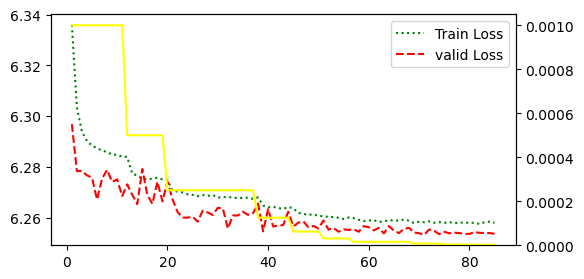

In [143]:
plt.plot(history.epoch, history.train_loss, "g:", label="Train Loss")
plt.plot(history.epoch, history.test_loss, "r--", label="valid Loss")
plt.legend()
ax2 = plt.twinx()
ax2.plot(history.epoch, history.lr, c="yellow", label="Learning Rate")
ax2.set_ylim(0, ax2.get_ylim()[1])


In [31]:
df_test=pd.read_csv(cfg.test_path)
df_test.columns
len(df_test.columns)

16

In [ ]:

d = next(iter(test_dataloader))[0]
pred = predict(d, model)
res = pd.DataFrame({
    "target":next(iter(test_dataloader))[1].flatten().cpu(), 
    "pred":pred
})
res["err"] = np.abs(res["target"] - res["pred"])
res

In [ ]:
plt.plot([res.target.min(), res.target.max()], [res.target.min(), res.target.max()], color="gray")
plt.scatter(res.target, res.pred, marker="x")
plt.ylim(res.pred.min()*2,res.pred.max()*2)

In [ ]:
plt.hist(res["pred"], bins=50)

# Submission

In [ ]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [ ]:
full_submission_data = df_raw.iloc[0:0,:]
full_prediction_data = pd.DataFrame([], columns=[""])
full_submission_data

In [ ]:
for (raw_df_test, _, sample_prediction) in iter_test: 
    
    full_submission_data = pd.concat((full_submission_data,raw_df_test), axis=0)

    df_test = add_info_columns(full_submission_data)
    x_test = df_test.loc[:,x_cols].iloc[-200:,:]
    x_test_normalized = normalize_features(x_test).fillna(0).values
    
    pred = predict(torch.Tensor(x_test_normalized).to(device), model)
    
    sample_prediction['target'] = pred
    env.predict(sample_prediction)

In [ ]:
sample_prediction

In [ ]:
plt.hist(sample_prediction["target"], bins=20)